In [105]:
import sklearn
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from statistics import median, mean
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier,RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import RocCurveDisplay
from sklearn.impute import KNNImputer

In [59]:
dir = "data/"

employee_survey = pd.read_csv(dir + "employee_survey_data.csv")
general = pd.read_csv(dir + "general_data.csv")
manager_survey = pd.read_csv(dir + "manager_survey_data.csv")
in_time = pd.read_csv(dir + "in_time.csv")
out_time = pd.read_csv(dir + "out_time.csv")

In [60]:
np.random.seed(4444)

# Sommaire

<ul>
    <li><a href="#es">Employe survey</a></li>
    <li><a href="#ge">General</a></li>
    <li><a href="#ms">Manager survey</a></li>
    <li><a href="#it">In Time</a></li>
    <li><a href="#ot">Out Time</a></li>
    <li><a href="#ld">Lien entre les dataset</a></li>
    <li><a href="#cc">Conclusion</a></li>
</ul>

# Définition des variables globales

In [61]:
nbEmploye = employee_survey["EmployeeID"].max()
print("Il y a", nbEmploye, "employés dans le dataset")

Il y a 4410 employés dans le dataset


# Employee survey
<div id="es"></div>

## Données contenues dans le set

In [62]:
employee_survey.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


## Anaylse des données vides

In [63]:
employee_survey.isnull().sum()

EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64

## Répartition des notes

<AxesSubplot:>

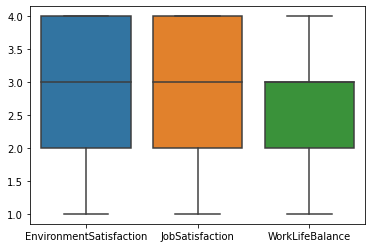

In [64]:
employee_survey_anonyme = employee_survey.drop(["EmployeeID"], axis=1, inplace=False)
sns.boxplot(data=employee_survey_anonyme)


<AxesSubplot:ylabel='Count'>

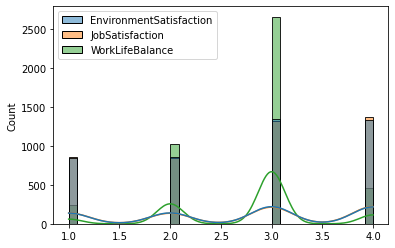

In [65]:
sns.histplot(data=employee_survey_anonyme, kde=True)

## Tendance des mauvais résultats

On regarde tout d'abord le nombre de gens qui sont insatisfait le l'environnement de travail et on remarque qu'ils représentent 38,5% des employés

In [66]:
BadEnvironmentSatisfaction = employee_survey[employee_survey['EnvironmentSatisfaction']<2.1].count()
print(BadEnvironmentSatisfaction['EnvironmentSatisfaction'] / nbEmploye * 100)
BadEnvironmentSatisfaction


38.57142857142858


EmployeeID                 1701
EnvironmentSatisfaction    1701
JobSatisfaction            1694
WorkLifeBalance            1685
dtype: int64

On fait la même chose pour la satisfaction sur leurs travail et on obtient des résultats similaires, ce qui confirme les boîtes a moustache

In [67]:
BadJobSatisfaction = employee_survey[employee_survey['JobSatisfaction']<2.1].count()
print(BadJobSatisfaction['JobSatisfaction'] / nbEmploye * 100)
BadJobSatisfaction

38.54875283446712


EmployeeID                 1700
EnvironmentSatisfaction    1694
JobSatisfaction            1700
WorkLifeBalance            1687
dtype: int64

Enfin on regarde l'équilibre entre la vie privée et professionelle, dans ce cas on obtient 28.5% des employés

In [68]:
BadWorkLifeBalance = employee_survey[employee_survey['WorkLifeBalance']<2.1].count()
print(BadWorkLifeBalance['WorkLifeBalance'] / nbEmploye * 100)
BadWorkLifeBalance

28.52607709750567


EmployeeID                 1258
EnvironmentSatisfaction    1250
JobSatisfaction            1254
WorkLifeBalance            1258
dtype: int64

Si on essaie de regarder les employés qui ont a la foie une balance mauvaise, et une satisfaction de leur travail et de leur environnement de travail faible on obtient 178 personne avec une très mauvaise expérience

In [69]:
BadEnvironmentSatisfaction = employee_survey[employee_survey['EnvironmentSatisfaction']<2.1]
BadSatisfaction = BadEnvironmentSatisfaction[BadEnvironmentSatisfaction['JobSatisfaction']<2.1]
BadAll = BadSatisfaction[BadSatisfaction['WorkLifeBalance']<2.1]
BadAll["EmployeeID"].count()

178

# General
<div id="ge"></div>

## Données contenue dans le set

In [70]:
general.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


## Analyse des données vides

In [71]:
general.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

## Modifications nécéssaires

### Variables discrètes hierarchiques

Ensuite, on remplace les valeurs dans "BusinessTravel" avec l'"OrdinalEncoder" car il y a un ordre hiérarchique entre les données

In [72]:
ord_enc = OrdinalEncoder(categories=[['Non-Travel','Travel_Rarely','Travel_Frequently']])
encoded = ord_enc.fit_transform(general[["BusinessTravel"]])
general.drop('BusinessTravel', axis=1)
general = general.assign(BusinessTravel = encoded) 

In [73]:
ord_enc = OrdinalEncoder(categories=[['No','Yes']])
encoded = ord_enc.fit_transform(general[["Attrition"]])
general.drop('Attrition', axis=1)
general = general.assign(Attrition = encoded) 

In [74]:
ord_enc = OrdinalEncoder(categories=[['N','Y']])
encoded = ord_enc.fit_transform(general[["Over18"]])
general.drop('Over18', axis=1)
general = general.assign(Over18 = encoded) 

### Variables discrètes indépendantes
Ensuite on remplace les valeurs dans "Department" avec le "OneHotEncoder" car il n'y a pas de hiérarchie entre les valeurs

In [75]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['Department']])
dpt_enc = pd.DataFrame(encoded.toarray())
dpt_enc = dpt_enc.rename(columns={0:'Department_HR', 1:'Department_Research & Development', 2:'Department_Sales'})
general.drop('Department', axis=1, inplace=True)
general = pd.concat([general, dpt_enc], axis=1)

In [76]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['EducationField']])
edu_enc = pd.DataFrame(encoded.toarray())
edu_enc = edu_enc.rename(columns={
    0:'Education_Human Resources', 
    1:'Education_Life Sciences', 
    2:'Education_Marketing', 
    3:'Education_Medical', 
    4:'Education_Other', 
    5:'Education_Technical Degreee'})
general.drop('EducationField', axis=1, inplace=True)
general = pd.concat([general, edu_enc], axis=1)

In [77]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['Gender']])
gen_enc = pd.DataFrame(encoded.toarray())
gen_enc = gen_enc.rename(columns={0:'Female', 1:'Male'})
general.drop('Gender', axis=1, inplace=True)
general = pd.concat([general, gen_enc], axis=1)


In [78]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['JobRole']])
job_enc = pd.DataFrame(encoded.toarray())
job_enc = job_enc.rename(columns={
    0:'Job_Healthcare Representative', 
    1:'Job_Human Resources', 
    2:'Job_Laboratory Technician', 
    3:'Job_Manager', 
    4:'Job_Manufacturing Director',
    5:'Job_Research Director',
    6:'Job_Research Scientist',
    7:'Job_Sales Executive',
    8:'Job_Sales Representative'})
general.drop('JobRole', axis=1, inplace=True)
general = pd.concat([general, job_enc], axis=1)

In [79]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['MaritalStatus']])
mar_enc = pd.DataFrame(encoded.toarray())
mar_enc = mar_enc.rename(columns={0:'Divorced', 1:'Married', 2:'Single'})
general.drop('MaritalStatus', axis=1, inplace=True)
general = pd.concat([general, mar_enc], axis=1)

La classe globale encoder fait strictement la même chose que les cellules précédentes a ceci près qu'elle peu être intégré au pipeline

In [80]:
class global_encoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, data):
        bus_enc = self.ordinal_encode(data['BusinessTravel'])
        data.drop(["BusinessTravel"], axis=1, inplace=True)
        att_enc = self.ordinal_encode(data['Attrition'])
        data.drop(["Attrition"], axis=1, inplace=True)
        ove_enc = self.ordinal_encode(data['Over18'])
        data.drop(["Over18"], axis=1, inplace=True)

        mar_enc = self.one_hot_encode(data['MaritalStatus'])
        data.drop(["MaritalStatus"], axis=1, inplace=True)
        dep_enc = self.one_hot_encode(data['Department'])
        data.drop(["Department"], axis=1, inplace=True)
        edu_enc = self.one_hot_encode(data['EducationField'])
        data.drop(["EducationField"], axis=1, inplace=True)
        job_enc = self.one_hot_encode(data['JobRole'])
        data.drop(["JobRole"], axis=1, inplace=True)
        gen_enc = self.one_hot_encode(data['Gender'])
        data.drop(["Gender"], axis=1, inplace=True)

        return pd.concat([data, mar_enc, bus_enc, att_enc, ove_enc, dep_enc, edu_enc, job_enc, gen_enc], axis=1)


    def one_hot_encode(self, column):
        one_enc = OneHotEncoder()
        encoded = one_enc.fit_transform(column)
        df_enc = pd.DataFrame(encoded.toarray())
        return df_enc.rename(columns=column.unique())
    
    def ordinal_encode(self, column):
        ord_enc = OrdinalEncoder(categories=column.unique())
        encoded = ord_enc.fit_transform(column)
        return pd.DataFrame(encoded.toarray())
        


In [81]:
general

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,...,Job_Laboratory Technician,Job_Manager,Job_Manufacturing Director,Job_Research Director,Job_Research Scientist,Job_Sales Executive,Job_Sales Representative,Divorced,Married,Single
0,51,0.0,1.0,6,2,1,1,1,131160,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,31,1.0,2.0,10,1,1,2,1,41890,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,32,0.0,2.0,17,4,1,3,4,193280,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,38,0.0,0.0,2,5,1,4,3,83210,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,32,0.0,1.0,10,1,1,5,1,23420,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,0.0,1.0,5,4,1,4406,1,60290,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4406,29,0.0,1.0,2,4,1,4407,1,26790,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4407,25,0.0,1.0,25,2,1,4408,2,37020,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4408,42,0.0,1.0,18,2,1,4409,1,23980,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Analyse générales

### Nombres de personnes qui ont quitté l'entreprise en 2016

In [82]:
peopleLeft = general[general["Attrition"] == 1]
print("Number of people who left the company:", peopleLeft.shape[0], "out of", general.shape[0], "employees")
print("Approx", round(peopleLeft.shape[0] / general.shape[0] * 100, 2), "% of the employees left the company")

Number of people who left the company: 711 out of 4410 employees
Approx 16.12 % of the employees left the company


### Heatmap

Grâce a cette HeatMap on remarque qu'il n'y a pas de réel corrélation significative entre les gens qui s'en vont et leurs situations

<AxesSubplot:>

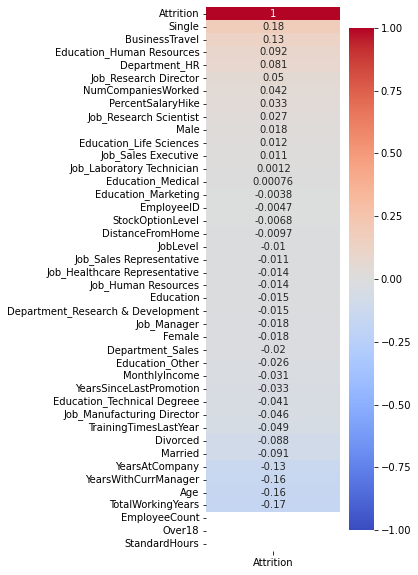

In [83]:
plt.figure(figsize=(3, 10))
general_corr = general.corr()
sns.heatmap(general_corr[['Attrition']].sort_values(by=['Attrition'],ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')

### Histogrammes

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'DistanceFromHome'}>,
        <AxesSubplot:title={'center':'Education'}>],
       [<AxesSubplot:title={'center':'JobLevel'}>,
        <AxesSubplot:title={'center':'MonthlyIncome'}>,
        <AxesSubplot:title={'center':'NumCompaniesWorked'}>],
       [<AxesSubplot:title={'center':'PercentSalaryHike'}>,
        <AxesSubplot:title={'center':'TotalWorkingYears'}>,
        <AxesSubplot:title={'center':'TrainingTimesLastYear'}>],
       [<AxesSubplot:title={'center':'YearsAtCompany'}>,
        <AxesSubplot:title={'center':'YearsSinceLastPromotion'}>,
        <AxesSubplot:title={'center':'YearsWithCurrManager'}>]],
      dtype=object)

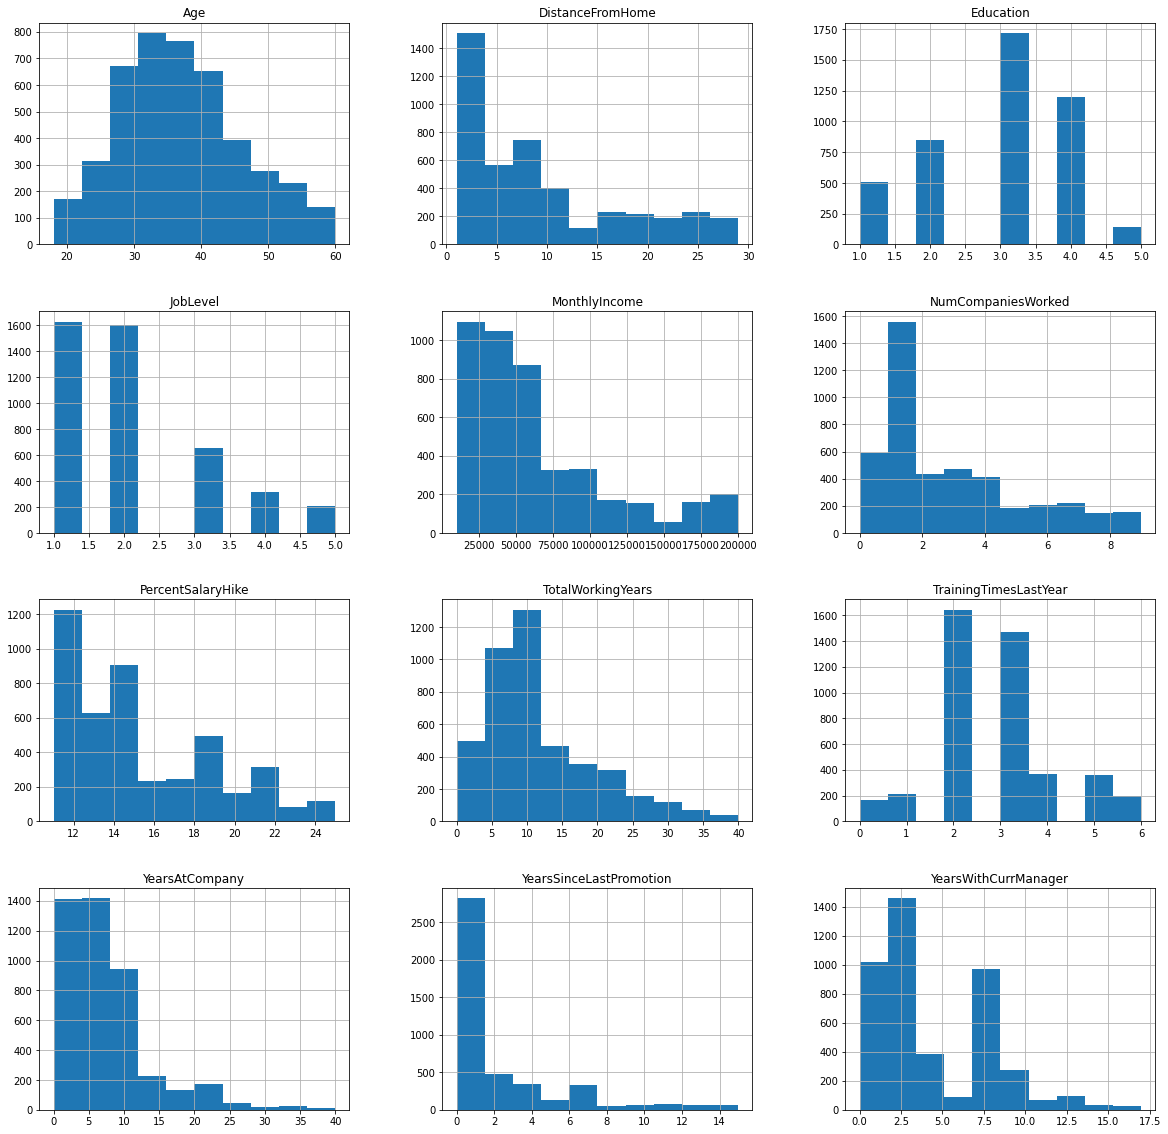

In [84]:
general.filter(items= ["Age","DistanceFromHome","Education","JobLevel", "MonthlyIncome", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", "TrainingTimesLastYear", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]).hist(figsize=(20,20))

# Manager survey
<div id="ms"></div>

## Données contenue dans le set

In [85]:
manager_survey.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


## Analyse des données vides

In [86]:
manager_survey.isnull().sum()

EmployeeID           0
JobInvolvement       0
PerformanceRating    0
dtype: int64

## Analyse générale

<AxesSubplot:>

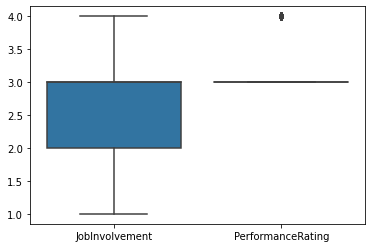

In [87]:
manager_survey_anonyme = manager_survey.drop(["EmployeeID"], axis=1, inplace=False)
sns.boxplot(data=manager_survey_anonyme)

#corréler avec attrition

# In Time
<div id="it"></div>

## Données contenues dans le dataset

In [88]:
in_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


## Analyse des données vides

In [89]:
print("Par date")
print(in_time.isnull().sum())
print("Par employé")
print(in_time.isnull().sum(axis=1))

Par date
Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64
Par employé
0       29
1       25
2       19
3       26
4       16
        ..
4405    18
4406    20
4407    30
4408    20
4409    29
Length: 4410, dtype: int64


## Répartition des données

<AxesSubplot:>

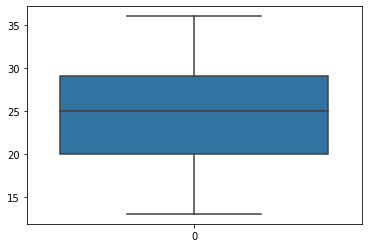

In [90]:

sns.boxplot(in_time.isnull().sum(axis=1))

# Out Time
<div id="ot"></div>

## Données contenues dans le set

In [91]:
out_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


## Analyse des données vides

In [92]:
print("Par date")
print(out_time.isnull().sum())
print("Par employé")
print(out_time.isnull().sum(axis=1))


Par date
Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64
Par employé
0       29
1       25
2       19
3       26
4       16
        ..
4405    18
4406    20
4407    30
4408    20
4409    29
Length: 4410, dtype: int64


## Répartition des données

<AxesSubplot:>

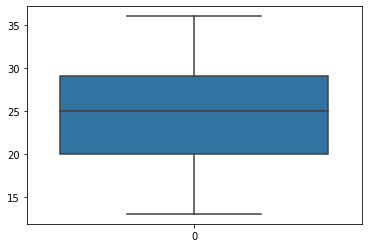

In [93]:

sns.boxplot(in_time.isnull().sum(axis=1))

# Lien entre des datasets
<div id="ld"></div>

## Données générales

### Base du temps

In [94]:
dayOff = in_time.isnull().sum() == 4410
print("Il y a", dayOff.sum() ,"jours de congés" )

Il y a 12 jours de congés


<AxesSubplot:>

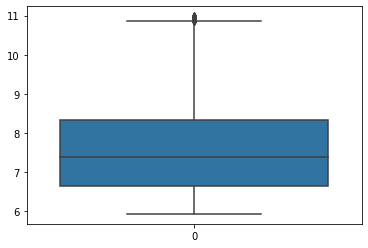

In [95]:
# average of the number of hours worked per day
in_time = in_time.dropna(axis=1, how='all')
out_time = out_time.dropna(axis=1, how='all')
in_time = in_time.dropna(axis=0, how='all')
out_time = out_time.dropna(axis=0, how='all')
in_time = in_time.apply(pd.to_datetime)
out_time = out_time.apply(pd.to_datetime)
hours_worked = out_time - in_time
hours_worked = hours_worked.applymap(lambda x: x.total_seconds() / 3600)
hours_worked = hours_worked.mean(axis=1)
hours_worked = hours_worked.dropna()
hours_worked = hours_worked.reset_index(drop=True)
sns.boxplot(hours_worked)



In [96]:
hours_worked_df = pd.DataFrame({
    "EmployeeID": general["EmployeeID"],
    "avg_hours_worked": hours_worked })
hours_worked_df

,EmployeeID,avg_hours_worked
0,1,7.342004
1,2,7.686399
2,3,6.984379
3,4,7.163197
4,5,7.973629
...,...,...
4405,4406,8.487350
4406,4407,6.067777
4407,4408,7.673414
4408,4409,9.453369


On remarque un taux plus élevé de démissions chez les gens qui travaillent le plus

<AxesSubplot:xlabel='avg_hours_worked', ylabel='Count'>

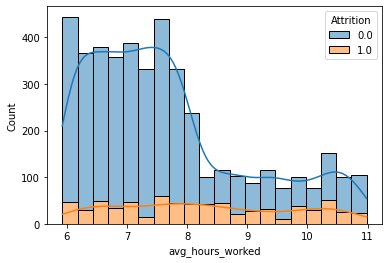

In [97]:
general_time = general.merge(hours_worked_df, on="EmployeeID")

sns.histplot(data=general_time, x="avg_hours_worked", hue="Attrition", multiple="stack", bins=20, kde=True)

In [98]:
general_badAll = general_time.merge(BadAll, on="EmployeeID", copy=True)

(general_badAll["Attrition"] == 0).sum()

133

In [99]:
out_timeAverage = out_time[out_time.columns[1:]].apply(pd.to_datetime)
out_timeAverage = out_timeAverage.apply(lambda x: (x - x.dt.normalize()).dt.total_seconds() / 3600)
out_timeAverage  = out_timeAverage.mean(axis=1)
out_timeAverage = out_timeAverage.to_frame()
out_timeAverage = out_timeAverage.assign(EmployeeID=range(1, len(out_timeAverage)+1))
out_timeAverage = out_timeAverage.rename(columns={0: 'avg_out_time'})

In [100]:
in_timeAverage = in_time[in_time.columns[1:]].apply(pd.to_datetime)
in_timeAverage = in_timeAverage.apply(lambda x: (x - x.dt.normalize()).dt.total_seconds() / 3600)
in_timeAverage = in_timeAverage.mean(axis=1)
in_timeAverage = in_timeAverage.to_frame()
in_timeAverage = in_timeAverage.assign(EmployeeID=range(1, len(in_timeAverage)+1))
in_timeAverage = in_timeAverage.rename(columns={0:'AverageStartTime'})

In [101]:
all_data = general.merge(manager_survey, on="EmployeeID", copy=True)
all_data = all_data.merge(employee_survey, on="EmployeeID", copy=True)
all_data = all_data.merge(hours_worked_df, on="EmployeeID", copy=True)
all_data = all_data.merge(out_timeAverage, on="EmployeeID", copy=True)
all_data = all_data.merge(in_timeAverage, on="EmployeeID", copy=True)

In [102]:
print(all_data["EmployeeID"].unique())
print(all_data["Over18"].unique())
print(all_data["StandardHours"].unique())

[   1    2    3 ... 4408 4409 4410]
[1.]
[8]


In [103]:
def dataCleaning(all_data, type):
    if type == 1:
        # drop useless columns
        all_data.drop("EmployeeID", axis=1, inplace=True)
        all_data.drop("Over18", axis=1, inplace=True)
        all_data.drop("EmployeeCount", axis=1, inplace=True)
        all_data.drop("StandardHours", axis=1, inplace=True)

    if type == 2:
        # drop unethical columns
        all_data.drop("Male", axis=1, inplace=True)
        all_data.drop("Female", axis=1, inplace=True)
        all_data.drop("Single", axis=1, inplace=True)
        all_data.drop("Married", axis=1, inplace=True)
        all_data.drop("Divorced", axis=1, inplace=True)
        all_data.drop("Age", axis=1, inplace=True)

    return all_data

all_data = dataCleaning(all_data,1)

In [104]:
plt.figure(figsize=(15, 10))
sns.heatmap(all_data.corr(numeric_only=True))

TypeError: DataFrame.corr() got an unexpected keyword argument 'numeric_only'

<Figure size 1080x720 with 0 Axes>

<AxesSubplot:>

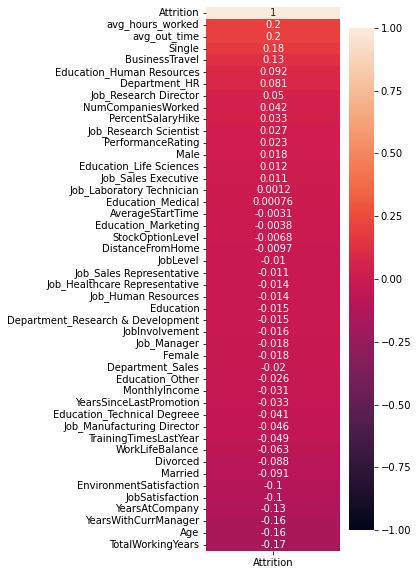

In [ ]:
plt.figure(figsize=(3, 10))
all_data_corr = all_data.corr()
sns.heatmap(all_data_corr[['Attrition']].sort_values(by=['Attrition'],ascending=False), vmin=-1, vmax=1, annot=True)

Lien entre age et temps travaillé

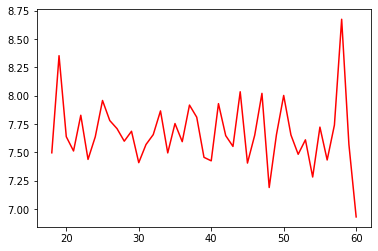

In [ ]:
age_hours_worked = all_data.groupby(['Age'])["avg_hours_worked"].mean()
plt.plot(age_hours_worked.index, age_hours_worked.values, color="red")

In [ ]:
all_data = dataCleaning(all_data,2)

# Gestion des valeurs manquantes

In [106]:
def nullToMedian(all_data):
    all_data["NumCompaniesWorked"] = all_data["NumCompaniesWorked"].replace(np.nan,median(all_data["NumCompaniesWorked"]))
    all_data["TotalWorkingYears"] = all_data["TotalWorkingYears"].replace(np.nan,median(all_data["TotalWorkingYears"]))

    all_data["EnvironmentSatisfaction"] = all_data["EnvironmentSatisfaction"].replace(np.nan,median(all_data["EnvironmentSatisfaction"]))
    all_data["JobSatisfaction"] = all_data["JobSatisfaction"].replace(np.nan,median(all_data["JobSatisfaction"]))
    all_data["WorkLifeBalance"] = all_data["WorkLifeBalance"].replace(np.nan,median(all_data["WorkLifeBalance"]))
    return all_data

def nullToKnnImputer(all_data):
    imputer = KNNImputer(n_neighbors=5)
    all_data_imputed = pd.DataFrame(imputer.fit_transform(all_data), columns=all_data.columns)
    return all_data_imputed

all_data = nullToKnnImputer(all_data)

# Normalisation

In [107]:
min_max_scaler = lambda x: (x-x.min()) / (x.max()-x.min())
all_data = all_data.apply(min_max_scaler)
all_data

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,...,Married,Single,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,avg_hours_worked,avg_out_time,AverageStartTime
0,0.785714,0.0,0.5,0.178571,0.25,0.00,0.637546,0.111111,0.000000,0.000000,...,1.0,0.0,0.666667,0.0,0.666667,1.000000,0.333333,0.280179,0.278397,0.455440
1,0.309524,1.0,1.0,0.321429,0.00,0.00,0.167457,0.000000,0.857143,0.333333,...,0.0,1.0,0.333333,1.0,0.666667,0.333333,1.000000,0.348247,0.343277,0.360231
2,0.333333,0.0,1.0,0.571429,0.75,0.75,0.964666,0.111111,0.285714,1.000000,...,1.0,0.0,0.666667,0.0,0.333333,0.333333,0.000000,0.209497,0.212578,0.624032
3,0.476190,0.0,0.0,0.035714,1.00,0.50,0.385045,0.333333,0.000000,1.000000,...,1.0,0.0,0.333333,0.0,1.000000,1.000000,0.666667,0.244839,0.239394,0.315702
4,0.333333,0.0,0.5,0.321429,0.00,0.00,0.070195,0.444444,0.071429,0.666667,...,0.0,1.0,0.666667,0.0,1.000000,0.000000,0.666667,0.405016,0.401445,0.434548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,0.571429,0.0,0.5,0.142857,0.75,0.00,0.264350,0.333333,0.428571,0.333333,...,0.0,1.0,0.666667,0.0,1.000000,0.000000,0.666667,0.506549,0.506475,0.586438
4406,0.261905,0.0,0.5,0.035714,0.75,0.00,0.087941,0.222222,0.285714,0.000000,...,0.0,0.0,0.333333,0.0,1.000000,1.000000,0.666667,0.028336,0.028650,0.475596
4407,0.166667,0.0,0.5,0.857143,0.25,0.25,0.141811,0.000000,0.642857,0.000000,...,1.0,0.0,0.666667,1.0,0.000000,0.666667,0.666667,0.345680,0.339283,0.302463
4408,0.571429,0.0,0.5,0.607143,0.25,0.00,0.073144,0.000000,0.214286,0.333333,...,0.0,0.0,0.333333,0.0,1.000000,0.000000,0.666667,0.697477,0.695871,0.577572


# Selection des caractéristiques

Le test du khi2 permet d'identifier les caractéristiques les plus pertinentes pour un modèle en évaluant leur indépendance par rapport à la variable cible.

In [108]:
# Préparer les données
y = all_data["Attrition"]
X = all_data.drop(columns=["Attrition"])

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [109]:
# Sélection des caractéristiques avec le test du khi2
k_best = SelectKBest(chi2, k="all")  # Utilisez un nombre approprié pour 'k' en fonction de vos données
X_train_kbest = k_best.fit_transform(x_train, y_train)
X_test_kbest = k_best.transform(x_test)

In [110]:
# Choisir un modèle (ici, nous utilisons la régression logistique)
model = LogisticRegression()

# Liste pour stocker les scores de validation croisée
cv_scores = []

In [111]:
max_features = x_train.shape[1]

# Boucle sur différentes valeurs de k
for k in range(1, max_features + 1):
    # Sélection des k meilleures caractéristiques
    k_best = SelectKBest(chi2, k=k)
    X_train_kbest = k_best.fit_transform(x_train, y_train)
    
    # Évaluation du modèle avec validation croisée k-fold (k = 5)
    scores = cross_val_score(model, X_train_kbest, y_train, cv=5)
    mean_score = np.mean(scores)
    cv_scores.append(mean_score)

# Trouver la valeur de k avec la meilleure performance
best_k = np.argmax(cv_scores) + 1
print(f"La meilleure valeur de k est {best_k}")

La meilleure valeur de k est 21


Nous avons donc déterminé que la valeur optimale de k est 21, nous garderons donc les 21 caractéristiques les plus importantes. Déterminons maintenant nos données finales à utiliser dans nos modèles.

In [112]:
# Sélection des caractéristiques avec le test du khi2
k_best = SelectKBest(chi2, k=best_k)
X_train_kbest = k_best.fit_transform(x_train, y_train)
X_test_kbest = k_best.transform(x_test)

# Récupérer les noms de colonnes sélectionnés
selected_features = x_train.columns[k_best.get_support()]

In [113]:
# Convertir les tableaux NumPy en DataFrames pandas avec les noms de colonnes appropriés
x_train = pd.DataFrame(X_train_kbest, columns=selected_features)
x_test = pd.DataFrame(X_test_kbest, columns=selected_features)

# Mise en place des modèles

In [114]:
def score(model, x_train, y_train):
    print("Accuracy:", cross_val_score(model, x_train, y_train, cv=7, scoring='accuracy').mean())
    print("F1 score:", cross_val_score(model, x_train, y_train, cv=7, scoring='f1').mean())
    print("Precision:", cross_val_score(model, x_train, y_train, cv=7, scoring='precision').mean())
    print("Recall:", cross_val_score(model, x_train, y_train, cv=7, scoring='recall').mean())
    print("ROC AUC score:", cross_val_score(model, x_train, y_train, cv=7, scoring='roc_auc').mean())

    fig, ax = plt.subplots(figsize=(8, 6))
    RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax)
    plt.show()

## Choix des hyperparamètres

### DecisionTreeClassifier

Pour le DecisionTreeClassifier nous allons utiliser GridSearch afin de trouver les meilleurs hyperparamètres

In [115]:
pipeline_dtc = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier())
])

In [116]:
criterion = ['gini', 'entropy']
max_depth = [16,18,20,21,22,23,24,30]
splitter = ['best','random']


parameters_dtc = dict(classifier__criterion=criterion,
                  classifier__max_depth=max_depth,
                  classifier__splitter=splitter)


In [173]:
dtc_GS = GridSearchCV(pipeline_dtc, parameters_dtc, cv=7)
dtc_GS.fit(x_train, y_train)

dtc_GS.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 18,
 'classifier__splitter': 'random'}

In [174]:
pd.DataFrame.from_dict(dtc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
19,0.006049,0.000278,0.001142,0.000353,entropy,18,random,"{'classifier__criterion': 'entropy', 'classifi...",0.968284,0.979478,0.990672,0.977570,0.988785,0.985047,0.990654,0.982927,0.007686,1
31,0.006115,0.000294,0.001714,0.000695,entropy,30,random,"{'classifier__criterion': 'entropy', 'classifi...",0.988806,0.981343,0.975746,0.973832,0.985047,0.985047,0.983178,0.981857,0.004963,2
11,0.007753,0.001319,0.001990,0.000533,gini,23,random,"{'classifier__criterion': 'gini', 'classifier_...",0.973881,0.981343,0.994403,0.973832,0.985047,0.985047,0.979439,0.981856,0.006675,3
27,0.005846,0.000638,0.001857,0.000351,entropy,23,random,"{'classifier__criterion': 'entropy', 'classifi...",0.979478,0.977612,0.977612,0.986916,0.979439,0.985047,0.985047,0.981593,0.003645,4
1,0.005832,0.000346,0.001572,0.000498,gini,16,random,"{'classifier__criterion': 'gini', 'classifier_...",0.985075,0.981343,0.977612,0.981308,0.971963,0.990654,0.981308,0.981323,0.005379,5


Accuracy: 0.9786571149592492
F1 score: 0.9229807583020015
Precision: 0.9220449722486831
Recall: 0.9339366861419788
ROC AUC score: 0.9701047174015885


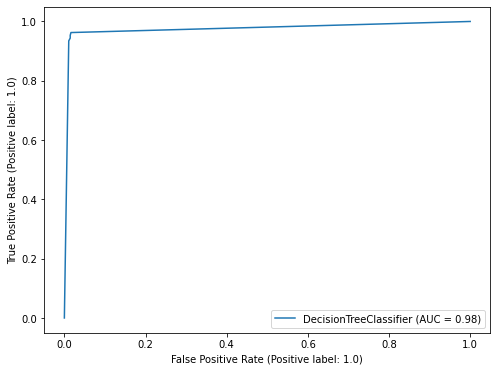

In [175]:
dtc = DecisionTreeClassifier(criterion = dtc_GS.best_params_['classifier__criterion'], max_depth = dtc_GS.best_params_['classifier__max_depth'], splitter = dtc_GS.best_params_['classifier__splitter'])

dtc.fit(x_train, y_train)

score(dtc, x_train, y_train)

Après plusieurs tests, on ressort qu'une max_depth de 22 et un criterion en entropy est le meilleur model que l'on peu avoir

In [176]:
y_pred_dtc = dtc.predict(x_test)

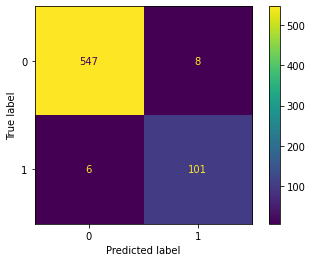

In [177]:
dtc_cm = confusion_matrix(y_test, y_pred_dtc)
dtc_cmd = ConfusionMatrixDisplay(confusion_matrix=dtc_cm,
                       display_labels=[0,1])

dtc_cmd.plot()
plt.show()


### HistGradientBoostingClassifier

In [178]:
pipeline_hgbc = Pipeline(steps=[
    ('classifier', HistGradientBoostingClassifier())
])

In [179]:
learning_rate = [0.1,0.2,0.3]
max_depth = [10,15,20,30]
loss = ['log_loss']
max_iter = [10,20,50,100,200]

parameters_hgbc = dict(classifier__learning_rate=learning_rate,
                  classifier__max_depth=max_depth,
                  classifier__loss=loss,
                  classifier__max_iter=max_iter
                  )

In [180]:
hgbc_GS = GridSearchCV(pipeline_hgbc, parameters_hgbc)
hgbc_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        HistGradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.2, 0.3],
                         'classifier__loss': ['log_loss'],
                         'classifier__max_depth': [10, 15, 20, 30],
                         'classifier__max_iter': [10, 20, 50, 100, 200]})

In [185]:
pd.DataFrame.from_dict(hgbc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__loss,param_classifier__max_depth,param_classifier__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
59,2.432929,0.021910,0.016300,0.002149,0.3,log_loss,30,200,"{'classifier__learning_rate': 0.3, 'classifier...",0.986667,0.986667,0.990667,0.989319,0.985314,0.987727,0.001962,1
54,2.360448,0.005117,0.015758,0.000746,0.3,log_loss,20,200,"{'classifier__learning_rate': 0.3, 'classifier...",0.986667,0.986667,0.990667,0.989319,0.985314,0.987727,0.001962,1
49,2.466211,0.065492,0.016650,0.001673,0.3,log_loss,15,200,"{'classifier__learning_rate': 0.3, 'classifier...",0.981333,0.988000,0.989333,0.987984,0.985314,0.986393,0.002847,3
44,2.315370,0.037051,0.015269,0.000430,0.3,log_loss,10,200,"{'classifier__learning_rate': 0.3, 'classifier...",0.984000,0.984000,0.989333,0.989319,0.982644,0.985859,0.002874,4
24,2.167445,0.053865,0.015581,0.001619,0.2,log_loss,10,200,"{'classifier__learning_rate': 0.2, 'classifier...",0.986667,0.989333,0.986667,0.987984,0.975968,0.985324,0.004781,5


Accuracy: 0.9922648107924994
F1 score: 0.9755840483902335
Precision: 0.9882315701519495
Recall: 0.9636460839347768
ROC AUC score: 0.9904934743656987


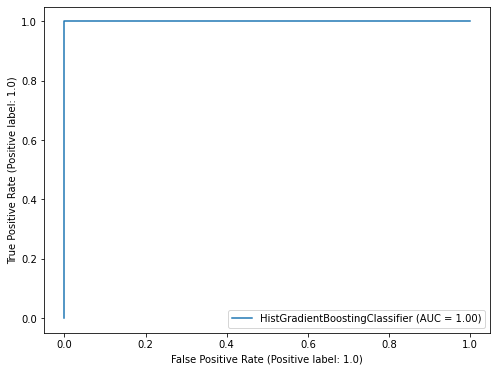

In [186]:
hgbc = HistGradientBoostingClassifier(learning_rate = hgbc_GS.best_params_['classifier__learning_rate'],max_depth= hgbc_GS.best_params_['classifier__max_depth'], max_iter=hgbc_GS.best_params_['classifier__max_iter'], loss=hgbc_GS.best_params_['classifier__loss'])

hgbc.fit(x_train, y_train)

score(hgbc, x_train, y_train)

In [187]:
y_pred_hgbc = hgbc.predict(x_test)

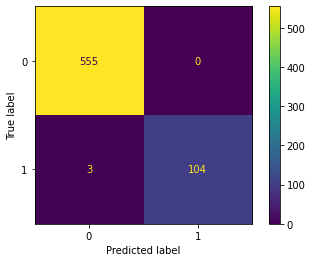

In [188]:
cm_hgbc = confusion_matrix(y_test, y_pred_hgbc)
cmd_hgbc = ConfusionMatrixDisplay(confusion_matrix=cm_hgbc,
                       display_labels=[0,1])

cmd_hgbc.plot()
plt.show()

### RandomForestClassifier

In [189]:
pipeline_rfc = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

In [190]:
n_estimators = [1,2,3,5,10,50,100,200,300]
criterion = ['gini', 'entropy']
max_depth = [5,10,14,18,22,24,30,50,100]


parameters_rfc = dict(classifier__n_estimators=n_estimators,
                  classifier__criterion=criterion,
                  classifier__max_depth=max_depth
                  )

In [191]:
rfc_GS = GridSearchCV(pipeline_rfc, parameters_rfc)
rfc_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [5, 10, 14, 18, 22, 24, 30,
                                                   50, 100],
                         'classifier__n_estimators': [1, 2, 3, 5, 10, 50, 100,
                                                      200, 300]})

In [192]:
pd.DataFrame.from_dict(rfc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
53,1.132044,0.014771,0.047471,0.000488,gini,24,300,"{'classifier__criterion': 'gini', 'classifier_...",0.982667,0.980000,0.984000,0.989319,0.983979,0.983993,0.003035,1
61,0.758508,0.010501,0.032295,0.000218,gini,30,200,"{'classifier__criterion': 'gini', 'classifier_...",0.981333,0.978667,0.986667,0.987984,0.985314,0.983993,0.003472,1
151,0.861663,0.007573,0.033311,0.000489,entropy,50,200,"{'classifier__criterion': 'entropy', 'classifi...",0.981333,0.980000,0.984000,0.987984,0.985314,0.983726,0.002840,3
124,1.043348,0.025420,0.039224,0.003146,entropy,22,200,"{'classifier__criterion': 'entropy', 'classifi...",0.982667,0.977333,0.984000,0.989319,0.983979,0.983460,0.003822,4
35,1.392656,0.059195,0.059153,0.006305,gini,18,300,"{'classifier__criterion': 'gini', 'classifier_...",0.981333,0.980000,0.982667,0.989319,0.983979,0.983460,0.003216,4


Accuracy: 0.9893310483629916
F1 score: 0.9673864523118808
Precision: 0.9945732838589981
Recall: 0.9404857371978462
ROC AUC score: 0.9967909646991292


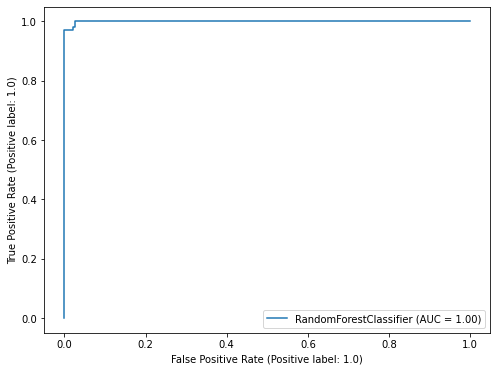

In [193]:
rfc = RandomForestClassifier(n_estimators=rfc_GS.best_params_['classifier__n_estimators'],criterion=rfc_GS.best_params_['classifier__criterion'],max_depth=rfc_GS.best_params_['classifier__max_depth'])

rfc.fit(x_train, y_train)

score(rfc, x_train, y_train)

In [194]:
y_pred_rfc = rfc.predict(x_test)

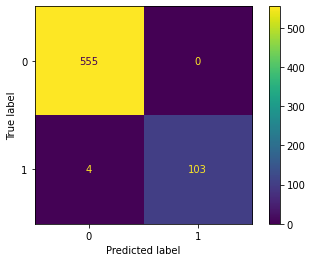

In [195]:
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
cmd_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc,
                       display_labels=[0,1])

cmd_rfc.plot()
plt.show()

### Perceptron

In [196]:
pipeline_pe = Pipeline(steps=[
    ('classifier', Perceptron())
])

In [197]:
penalty = ['l2','l1','elasticnet']
alpha = [0.0001,0.0002,0.0003,0.0005]


parameters_pe = dict(classifier__penalty=penalty,
                  classifier__alpha=alpha)


In [198]:
pe_GS = GridSearchCV(pipeline_pe, parameters_pe)
pe_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier', Perceptron())]),
             param_grid={'classifier__alpha': [0.0001, 0.0002, 0.0003, 0.0005],
                         'classifier__penalty': ['l2', 'l1', 'elasticnet']})

In [199]:
pd.DataFrame.from_dict(pe_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.011362,0.003476,0.001796,0.000399,0.0005,elasticnet,"{'classifier__alpha': 0.0005, 'classifier__pen...",0.850667,0.850667,0.852000,0.838451,0.842457,0.846848,0.005394,1
10,0.006783,0.001184,0.001761,0.000389,0.0005,l1,"{'classifier__alpha': 0.0005, 'classifier__pen...",0.854667,0.820000,0.845333,0.838451,0.850467,0.841784,0.012162,2
9,0.004005,0.000909,0.001307,0.000258,0.0005,l2,"{'classifier__alpha': 0.0005, 'classifier__pen...",0.818667,0.830667,0.838667,0.843792,0.846462,0.835651,0.010055,3
0,0.004790,0.000763,0.007769,0.011591,0.0001,l2,"{'classifier__alpha': 0.0001, 'classifier__pen...",0.816000,0.829333,0.841333,0.802403,0.841121,0.826038,0.015044,4
5,0.012574,0.002253,0.002047,0.000097,0.0002,elasticnet,"{'classifier__alpha': 0.0002, 'classifier__pen...",0.848000,0.838667,0.712000,0.839786,0.849132,0.817517,0.052926,5


Accuracy: 0.804445230456529
F1 score: 0.3006320213489882
Precision: 0.5039757981895303
Recall: 0.33318058578684084
ROC AUC score: 0.7652075465792841


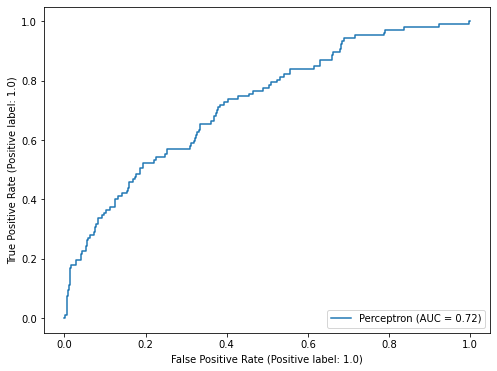

In [200]:
pe = Perceptron(penalty=pe_GS.best_params_['classifier__penalty'],alpha = pe_GS.best_params_['classifier__alpha'])

pe.fit(x_train, y_train)

score(pe, x_train, y_train)

In [201]:
y_pred_pe = pe.predict(x_test)

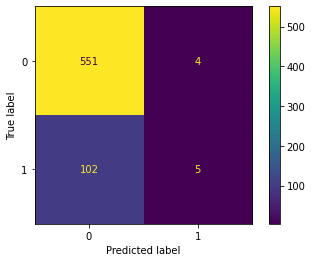

In [202]:
cm_pe = confusion_matrix(y_test, y_pred_pe)
cmd_pe = ConfusionMatrixDisplay(confusion_matrix=cm_pe,
                       display_labels=[0,1])

cmd_pe.plot()
plt.show()

### Logistic Regression

In [203]:
pipeline_lr = Pipeline(steps=[
    ('classifier', LogisticRegression())
])

In [204]:
penalty = ['l2']
max_iter = [100,500,1000]


parameters_lr = dict(classifier__penalty = penalty,
                  classifier__max_iter = max_iter)

In [205]:
lr_GS = GridSearchCV(pipeline_lr, parameters_lr)
lr_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid={'classifier__max_iter': [100, 500, 1000],
                         'classifier__penalty': ['l2']})

In [206]:
pd.DataFrame.from_dict(lr_GS.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_iter,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024779,0.003311,0.001596,0.000489,100,l2,"{'classifier__max_iter': 100, 'classifier__pen...",0.858667,0.854667,0.86,0.861148,0.87984,0.862864,0.008765,1
1,0.022587,0.001386,0.001396,0.000488,500,l2,"{'classifier__max_iter': 500, 'classifier__pen...",0.858667,0.854667,0.86,0.861148,0.87984,0.862864,0.008765,1
2,0.022866,0.001393,0.001601,0.000483,1000,l2,"{'classifier__max_iter': 1000, 'classifier__pe...",0.858667,0.854667,0.86,0.861148,0.87984,0.862864,0.008765,1


Accuracy: 0.8620653408524799
F1 score: 0.3702022834619682
Precision: 0.70571626109609
Recall: 0.2533127124145569
ROC AUC score: 0.810996537410434


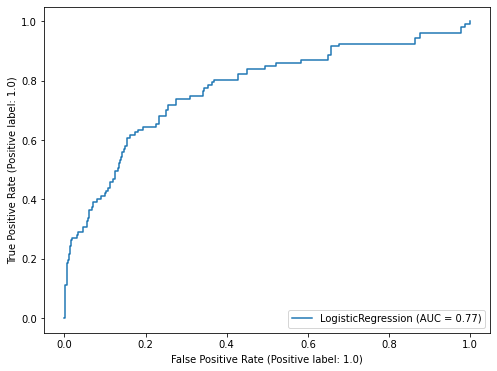

In [207]:
lr = LogisticRegression(penalty=lr_GS.best_params_['classifier__penalty'], max_iter=lr_GS.best_params_['classifier__max_iter'] )

lr.fit(x_train, y_train)

score(lr, x_train, y_train)

In [208]:
y_pred_lr = lr.predict(x_test)

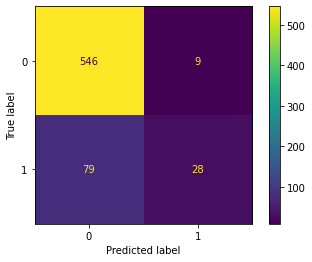

In [209]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cmd_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                       display_labels=[0,1])

cmd_lr.plot()
plt.show()

# Analyse des résultats

### DecisionTreeClassifier

In [210]:
cl_dtc = list(zip(x_train.columns, dtc.feature_importances_))
coefs_dtc = pd.DataFrame(cl_dtc, columns = ['Column', 'Coefs'])
coefs_dtc.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
19,avg_hours_worked,0.132423
3,TotalWorkingYears,0.094110
4,YearsAtCompany,0.085288
6,YearsWithCurrManager,0.083370
18,JobSatisfaction,0.079409
5,YearsSinceLastPromotion,0.063907
2,NumCompaniesWorked,0.058177
17,EnvironmentSatisfaction,0.049075
20,avg_out_time,0.040544
0,Age,0.040257


### HistGradientBoostingClassifier

L'analyse des résutats d'un HistGradientBoostingClassifier est complexe car ce modèle est capable de capturer des relations non-linéaires entre nos differentes données.
Il est donc difficile de comprendre comment ces relations non-linéaires contribuent à la prédiction du modèle.

### RandomForestClassifier

In [212]:
cl_rfc = list(zip(x_train.columns, rfc.feature_importances_))
coefs_rfc= pd.DataFrame(cl_rfc, columns = ['Column', 'Coefs'])
coefs_rfc.sort_values(by=['Coefs'], ascending=False)


,Column,Coefs
19,avg_hours_worked,0.130028
20,avg_out_time,0.126444
0,Age,0.114903
3,TotalWorkingYears,0.099415
4,YearsAtCompany,0.073564
2,NumCompaniesWorked,0.060211
6,YearsWithCurrManager,0.058546
17,EnvironmentSatisfaction,0.057486
18,JobSatisfaction,0.050843
5,YearsSinceLastPromotion,0.048864


### Perceptron

In [213]:
cl_pe = list(zip(x_train.columns, pe.coef_[0]))
coefs_pe = pd.DataFrame(cl_pe, columns = ['Column', 'Coefs'])
coefs_pe.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
5,YearsSinceLastPromotion,2.891495
2,NumCompaniesWorked,1.882087
19,avg_hours_worked,0.836868
20,avg_out_time,0.807927
1,BusinessTravel,0.290444
9,Education_Human Resources,0.021572
16,Single,0.000000
15,Married,0.000000
13,Job_Research Director,0.000000
11,Female,0.000000


### LogisticRegression

In [214]:
cl_lr = list(zip(x_train.columns, lr.coef_[0]))
coefs_lr = pd.DataFrame(cl_lr, columns = ['Column', 'Coefs'])
coefs_lr.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
5,YearsSinceLastPromotion,2.108534
1,BusinessTravel,1.430210
19,avg_hours_worked,1.175462
20,avg_out_time,1.139318
2,NumCompaniesWorked,1.123929
16,Single,0.660314
9,Education_Human Resources,0.528734
7,Department_HR,0.497271
13,Job_Research Director,0.230455
11,Female,-0.149982


# Conclusion
<div id="cc"></div>

Le choix du modèle de machine learning dépend de nombreux facteurs tels que la taille et la qualité des données, le type de problème à résoudre et les objectifs de performance. Dans le cas présent, nous avons éliminé HistGradientBoostingClassifier en raison de son manque d'interprétabilité, et le perceptron ainsi que la régression logistique en raison de résultats inexploitables.

Finalement, le DecisionTreeClassifier a été choisi comme modèle car il est plus facile à comprendre que le RandomForestClassifier. Il est donc plus facile d'expliquer les relations possibles entre nos différentes données et donc de proposer des pistes d'amélioration pour réduire le turn over.

## Etudes pour HumanForYou

Dans cette partie, nous proposons plusieurs pistes d'amélioration pour aider HumanForYou à réduire 
son taux de turn-over et à améliorer la satisfaction des employés. Nos recommandations sont basées 
sur l'analyse des données fournies et les modèles développés dans le respect des principes éthiques

In [220]:
coefs_dtc.sort_values(by=['Coefs'], ascending=False).head(6)

,Column,Coefs
19,avg_hours_worked,0.132423
3,TotalWorkingYears,0.094110
4,YearsAtCompany,0.085288
6,YearsWithCurrManager,0.083370
18,JobSatisfaction,0.079409
5,YearsSinceLastPromotion,0.063907


### Opportunités de formation et de développement professionnel
Le nombre de jours de formation et les années depuis la dernière promotion (YearsSinceLastPromotion) sont des facteurs 
influençant le taux de turn-over. Il est essentiel d'offrir des opportunités de formation et de 
développement professionnel pour maintenir l'engagement des employés. HumanForYou pourrait 
mettre en place un programme de formation continue et un système de mentorat pour soutenir les 
employés dans leur évolution professionnelle.
### Amélioration de l'équilibre travail-vie personnelle
Les données montrent que le temps passé au travail (avg_hours_worked & avg_out_time) est un facteur important 
pour la satisfaction des employés. L'entreprise pourrait proposer des options de travail flexibles, 
comme le télétravail, des horaires ajustables ou la mise en place d'un système de crédit-temps pour 
encourager une meilleure conciliation entre la vie professionnelle et personnelle.
### Satisfaction de l'environnement de travail 
Les employés qui se sentent satisfaits de leur environnement de travail (EnvironmentSatisfaction) sont plus susceptibles de 
rester dans l'entreprise. HumanForYou devrait examiner les conditions de travail, les installations et 
les équipements pour s'assurer qu'ils sont bien adaptés aux besoins des employés. Des enquêtes 
régulières sur la qualité de vie au travail peuvent aider à identifier les domaines à améliorer.

En mettant en œuvre ces pistes d'amélioration, HumanForYou peut créer un environnement de 
travail plus attrayant et réduire le taux de turn-over. Il est important de suivre régulièrement 
l'efficacité de ces initiatives et d'ajuster les stratégies en conséquence, en tenant compte des retours 
des employés et des nouvelles informations issues de l'analyse des données